# Intro

**Objective**

Develop a model that predicts whether a Kickstarter.com campain cover image is from a successful or failed campaign. Interpretability of the feature importance is the focus of this effort. I wish to provide suggestions to improve campaign images and alert users which features are important.


Author: Nicholas Mostovych

References: Code snippets references from Mauro Di Pietro article: Machine Learning with Python: Classification

# Imports

In [1]:
## for data
import pandas as pd
import numpy as np
import joblib
import pickle


## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


## for explainer
from lime import lime_tabular

## Interactive env
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
features_table = '/home/mosto/Documents/insight/kickstarter-project/final_features_df1.pkl'
features = joblib.load(features_table)
# Remove campaigns with a state = 2 which means they are still ongoing 
dtf = features[features.state !=2]
dtf.head()

,image,dullness,brightness,uniformity,average_color,average_red,average_green,average_blue,compression_size,temp_size,...,dominant_green,dominant_blue,state,pledged,goal,backers,staff_pick,launched_at,deadline,category
0,94899,0.00,60.88,0.768534,"[240.86637708875867, 212.18375311957465, 138.9...",0.944574,0.832093,0.545000,39944,"(1024, 576)",...,1.000000,0.996078,0,60.00,5000.0,5000.0,0.0,1.302576e+09,1.306464e+09,Graphic Design
1,162481,0.00,0.00,5.192227,"[118.4811774359809, 128.5906219482422, 125.515...",0.464632,0.504277,0.492219,165701,"(1024, 576)",...,0.309804,0.352941,0,326.00,1000.0,1000.0,0.0,1.303708e+09,1.306300e+09,Electronic Music
2,201573,0.00,0.00,5.105082,"[102.67853122287326, 92.08284335666232, 180.79...",0.402661,0.361109,0.708983,140637,"(1024, 576)",...,0.160784,0.850980,0,215.00,500.0,500.0,0.0,1.578081e+09,1.580612e+09,Crochet
3,159292,0.00,0.00,2.721759,"[75.76579604633861, 110.38401914242864, 143.18...",0.297121,0.432879,0.561527,250948,"(1552, 873)",...,0.600000,0.729412,1,407.01,300.0,300.0,0.0,1.311861e+09,1.313108e+09,Conceptual Art
4,68557,7.93,0.00,0.367261,"[89.36553211464201, 97.02202309254733, 109.570...",0.350453,0.380479,0.429687,963059,"(1552, 873)",...,0.164706,0.164706,1,14041.00,12000.0,12000.0,1.0,1.401988e+09,1.405099e+09,World Music


In [3]:
# Define variable names
col_names = dtf.columns

In [4]:
# Check Dtypes
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9727 entries, 0 to 10892
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             9727 non-null   int64  
 1   dullness          9701 non-null   float64
 2   brightness        9701 non-null   float64
 3   uniformity        9727 non-null   float64
 4   average_color     9727 non-null   object 
 5   average_red       9727 non-null   float64
 6   average_green     9727 non-null   float64
 7   average_blue      9727 non-null   float64
 8   compression_size  9727 non-null   int64  
 9   temp_size         9727 non-null   object 
 10  width             9727 non-null   int64  
 11  height            9727 non-null   int64  
 12  blurriness        9727 non-null   float64
 13  dominant_color    9727 non-null   object 
 14  dominant_red      9727 non-null   float64
 15  dominant_green    9727 non-null   float64
 16  dominant_blue     9727 non-null   float64

In [5]:
# Remove rows with null values
dtf = dtf.dropna(how='any',axis=0)

# Data Analysis

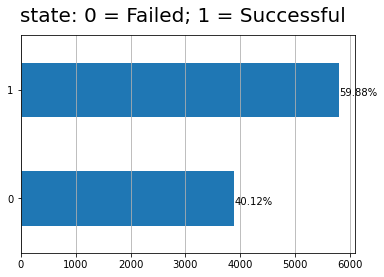

In [6]:
# Look at class balance
y = "state"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y+': 0 = Failed; 1 = Successful', fontsize=20)
plt.show()

In [7]:
# Review our dependent variables
col_names

Index(['image', 'dullness', 'brightness', 'uniformity', 'average_color',
       'average_red', 'average_green', 'average_blue', 'compression_size',
       'temp_size', 'width', 'height', 'blurriness', 'dominant_color',
       'dominant_red', 'dominant_green', 'dominant_blue', 'state', 'pledged',
       'goal', 'backers', 'staff_pick', 'launched_at', 'deadline', 'category'],
      dtype='object')

In [8]:
# Select the features to analyze
col_names = ['dullness','brightness','uniformity','average_red','average_green','average_blue',
             'dominant_red','dominant_green','dominant_blue','blurriness','compression_size']
print(col_names)
print(str(len(col_names))+' features')

['dullness', 'brightness', 'uniformity', 'average_red', 'average_green', 'average_blue', 'dominant_red', 'dominant_green', 'dominant_blue', 'blurriness', 'compression_size']
11 features


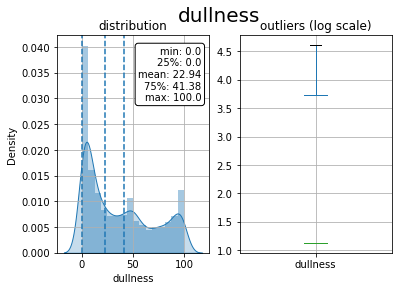

In [9]:
# Inspect a few variables individually
x = col_names[0]
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]

sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

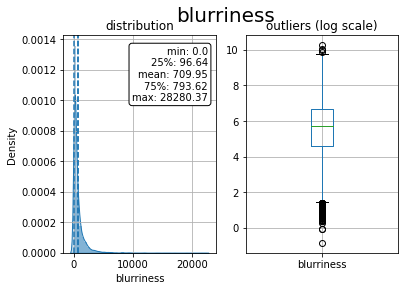

In [10]:
# Inspect a few variables individually
x = col_names[9]
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]

sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

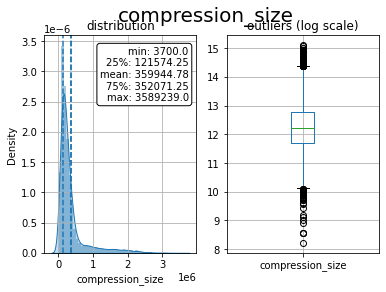

In [11]:
# Inspect a few variables individually
x = col_names[10]
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]

sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

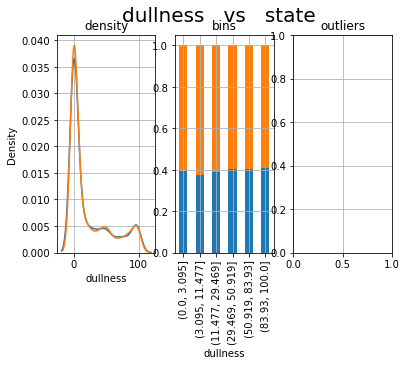

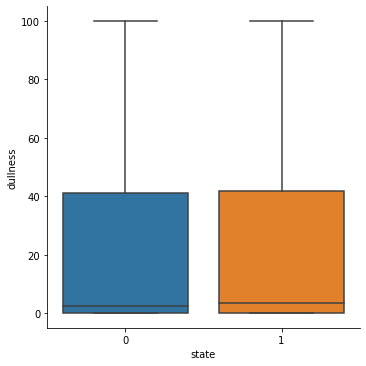

In [12]:
# Check if these features seem to be predictive of class
cat, num = "state", col_names[0]

fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(num+"   vs   "+cat, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=dtf, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

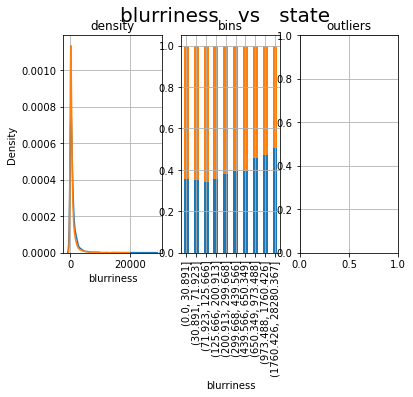

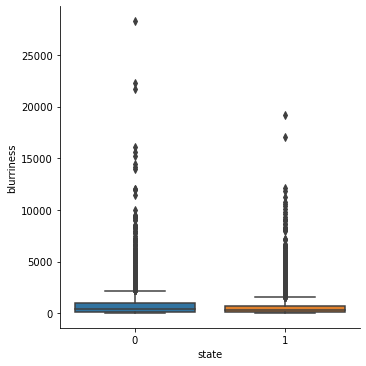

In [13]:
# Check if these features seem to be predictive of class
cat, num = "state", col_names[9]

fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(num+"   vs   "+cat, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=dtf, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

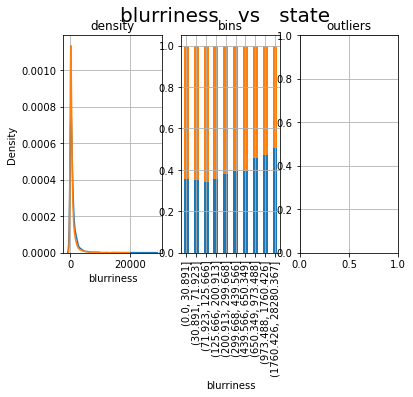

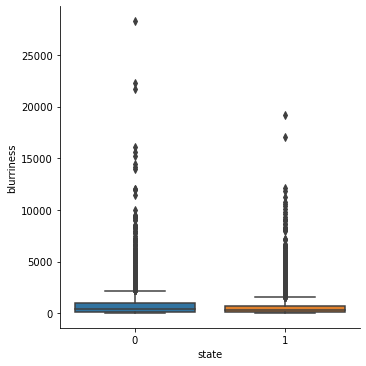

In [14]:
# Check if these features seem to be predictive of class
cat, num = "state", col_names[9]

fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(num+"   vs   "+cat, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=dtf, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

In [15]:
# Look at p-values of the selected variables
cat, num = "state", col_names[0]

model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables Class and " + num + " are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables Class and dullness are Non-Correlated (p-value: 0.876)


In [16]:
# Look at p-values of the selected variables
cat, num = "state", col_names[9]

model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables Class and " + num + " are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables Class and blurriness are Correlated (p-value: 0.0)


In [17]:
# Look at p-values of the selected variables
cat, num = "state", col_names[10]

model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables Class and " + num + " are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables Class and compression_size are Correlated (p-value: 0.0)


# Preprocessing

In [18]:
## Select only features to analyze
dtf = dtf.loc[:,['dullness','brightness','uniformity','average_red','average_green','average_blue',
                 'dominant_red','dominant_green','dominant_blue','blurriness','compression_size','state']]
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9688 entries, 0 to 10892
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dullness          9688 non-null   float64
 1   brightness        9688 non-null   float64
 2   uniformity        9688 non-null   float64
 3   average_red       9688 non-null   float64
 4   average_green     9688 non-null   float64
 5   average_blue      9688 non-null   float64
 6   dominant_red      9688 non-null   float64
 7   dominant_green    9688 non-null   float64
 8   dominant_blue     9688 non-null   float64
 9   blurriness        9688 non-null   float64
 10  compression_size  9688 non-null   int64  
 11  state             9688 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 1.3 MB


In [19]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, 
                      test_size=0.2)

X_train = dtf_train.drop("state",axis=1)
y_train = dtf_train['state']
X_test = dtf_test.drop("state",axis=1)
y_test = dtf_test['state']

## print info
print("X_train shape:", dtf_train.drop("state",axis=1).shape, "| X_test shape:", dtf_test.drop("state",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["state"]),2), "| y_test mean:", round(np.mean(dtf_test["state"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("state",axis=1).columns.to_list())

X_train shape: (7750, 11) | X_test shape: (1938, 11)
y_train mean: 0.6 | y_test mean: 0.6
12 features: ['dullness', 'brightness', 'uniformity', 'average_red', 'average_green', 'average_blue', 'dominant_red', 'dominant_green', 'dominant_blue', 'blurriness', 'compression_size']


# Feature Correlation

Text(0.5, 1.0, 'pearson correlation')

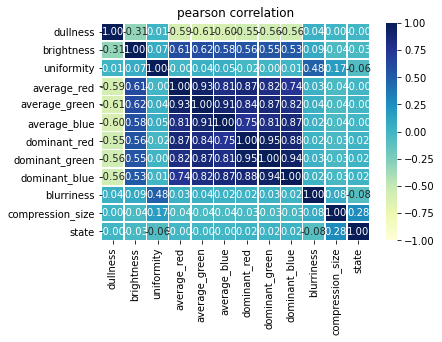

In [20]:
# Let's look at the pearson correlation matrix
corr_matrix = dtf.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
            
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

# Logistic Regression Model

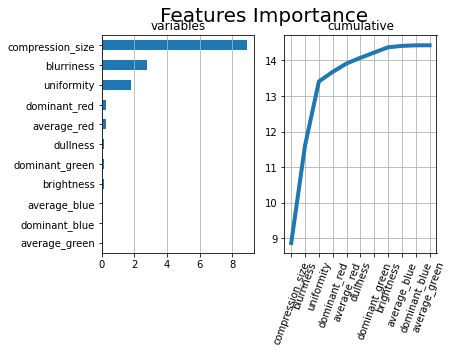

In [21]:
# Scaling Data
'''
Many of the features are not normally distributed such as RGB values
(i.e. dont have gaussian form) so using gaussian scaling would move data
away from zero compared to minmax scaling so I elect to use minmax

Here is standard scalar approach as reference:
scaler = StandardScaler()
X = dtf.drop(['state'], axis=1)
scaler.fit(X) 
'''

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_fit_scaled = scaler.fit_transform(dtf_train.drop(['state'], axis=1))

y = dtf_train["state"].values
feature_names = dtf_train.drop("state", axis=1).columns.tolist()

## Importance
model = LogisticRegression(random_state=0)
model.fit(X_fit_scaled,y)
importances = abs(model.coef_[0])

## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0) 
            
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')

dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

# Validation of Logistic Regression Model

In [22]:
## train
model.fit(X_train, y_train)

## test
predicted_prob = model.predict_proba(X_test)[:,1]
predicted = model.predict(X_test)

In [24]:
## Accuray and AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision and Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.65
Auc: 0.81
Recall (all 1s predicted right): 0.96
Precision (confidence when predicting a 1): 0.64
Detail:
              precision    recall  f1-score   support

           0       0.73      0.18      0.29       777
           1       0.64      0.96      0.76      1161

    accuracy                           0.65      1938
   macro avg       0.69      0.57      0.53      1938
weighted avg       0.68      0.65      0.57      1938



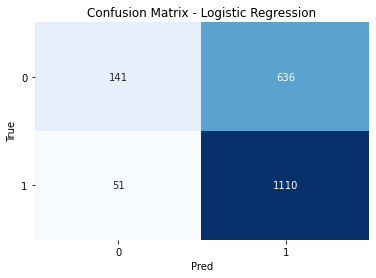

In [25]:
# Visualize Confusion Matrix 
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion Matrix - Logistic Regression")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

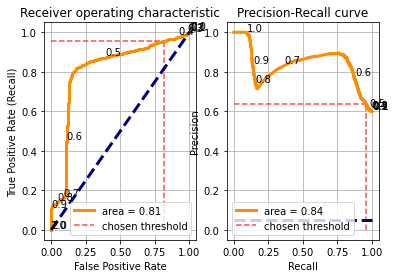

In [26]:
# Threshold Sensitivity Testing

classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2)

## plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)
roc_auc = metrics.auc(fpr, tpr)     
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
ax[0].legend(loc="lower right")
ax[0].grid(True)

## annotate ROC thresholds
thres_in_plot = []
for i,t in enumerate(thresholds):
     t = np.round(t,1)
     if t not in thres_in_plot:
         ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), 
              textcoords='offset points', ha='left', va='bottom')
         thres_in_plot.append(t)
     else:
         next
            
## plot P-R curve
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)

## annotate P-R thresholds
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
         ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), 
               xytext=(recalls[i],precisions[i]), 
               textcoords='offset points', ha='left', va='bottom')
         thres_in_plot.append(t)
    else:
         next
plt.show()

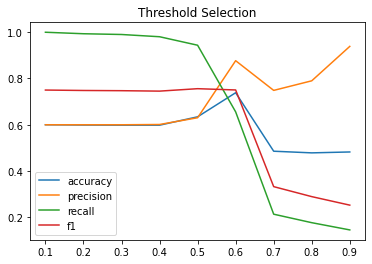

In [27]:
## calculate scores for different thresholds
dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]

thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted))
        
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))    
dtf_scores.plot(title="Threshold Selection")
plt.show()

# Random Forest Model

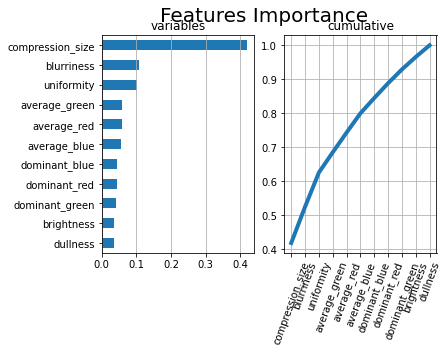

In [28]:
# Random Forest 
X = dtf_train.drop("state", axis=1).values
y = dtf_train["state"].values
feature_names = dtf_train.drop("state", axis=1).columns.tolist()

## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_

## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0) 
            
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')

dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

<AxesSubplot:ylabel='Features'>

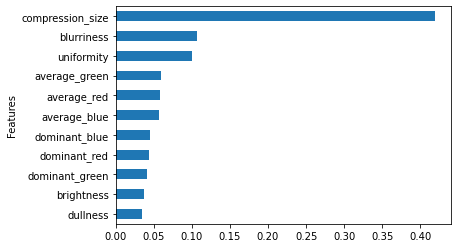

In [43]:
#fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
import matplotlib.pyplot as plt
#fig.suptitle("Features Importance", fontsize=20)
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(ylabel = 'Relative Importance',
                xlabel = 'Features', kind="barh", xticks=None, legend=False)

# Validation of Random Forest Model 

In [44]:
## train
model.fit(X_train, y_train)

## test
predicted_prob = model.predict_proba(X_test)[:,1]
predicted = model.predict(X_test)

In [45]:
## Accuray and AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision and Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.89
Auc: 0.96
Recall (all 1s predicted right): 0.92
Precision (confidence when predicting a 1): 0.9
Detail:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       777
           1       0.90      0.92      0.91      1161

    accuracy                           0.89      1938
   macro avg       0.88      0.88      0.88      1938
weighted avg       0.89      0.89      0.89      1938



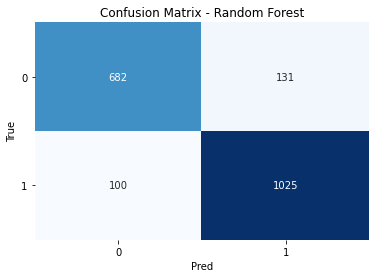

In [37]:
# Visualize Confusion Matrix 
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion Matrix - Random Forest")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

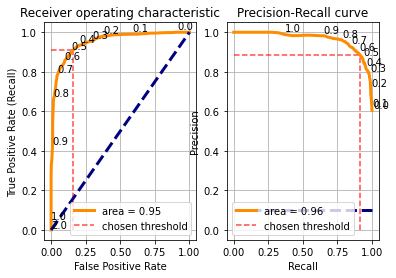

In [38]:
# Threshold Sensitivity Testing
classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2)

## plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)
roc_auc = metrics.auc(fpr, tpr)     
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
ax[0].legend(loc="lower right")
ax[0].grid(True)

## annotate ROC thresholds
thres_in_plot = []
for i,t in enumerate(thresholds):
     t = np.round(t,1)
     if t not in thres_in_plot:
         ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), 
              textcoords='offset points', ha='left', va='bottom')
         thres_in_plot.append(t)
     else:
         next
            
## plot P-R curve
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)

## annotate P-R thresholds
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
         ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), 
               xytext=(recalls[i],precisions[i]), 
               textcoords='offset points', ha='left', va='bottom')
         thres_in_plot.append(t)
    else:
         next
plt.show()

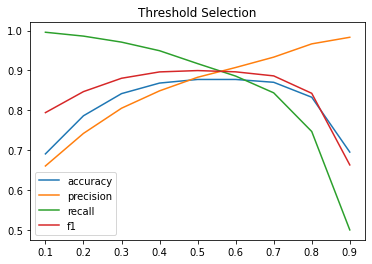

In [39]:
## calculate scores for different thresholds
dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]

thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted))
        
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))    
dtf_scores.plot(title="Threshold Selection")
plt.show()

# Save Model

In [40]:
# Serialize the data table containing the scraped HTML for each project
joblib.dump(model.fit(X_train, y_train), 
            '/home/mosto/Documents/insight/kickstarter-project/kit_RFM_10_20_20.pkl')

['/home/mosto/Documents/insight/kickstarter-project/kit_RFM_10_20_20.pkl']